# 1- Import Libs

In [3]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np 
import warnings 
import re, nltk,string
from nltk.stem import WordNetLemmatizer
import squarify
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter
from nltk.tokenize import word_tokenize
from gensim.parsing.preprocessing import remove_stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder


nltk.download('stopwords')
nltk.download('punkt')
nltk.download('stopwords')
warnings.filterwarnings('ignore')
%matplotlib inline

color = sns.color_palette()
pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abdel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abdel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abdel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 2- Load Data & Understanding it

In [4]:
df_train = pd.read_csv("Data/drugsComTrain_raw.csv", parse_dates=["date"])
df_test = pd.read_csv("Data/drugsComTest_raw.csv", parse_dates=["date"])

In [5]:
print("Train shape :" ,df_train.shape)
print("Test shape :", df_test.shape)

Train shape : (161297, 7)
Test shape : (53766, 7)


In [6]:
df_train.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,2012-05-20,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,2010-04-27,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,2009-12-14,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,2015-11-03,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,2016-11-27,37


In [7]:
df_train.review[0]

'"It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil"'

In [7]:
df_test.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,2012-02-28,22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,2009-05-17,17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,2017-09-29,3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,2017-03-05,35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,2015-10-22,4


In [8]:
df_all = pd.concat([df_train,df_test])

In [9]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215063 entries, 0 to 53765
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   uniqueID     215063 non-null  int64         
 1   drugName     215063 non-null  object        
 2   condition    213869 non-null  object        
 3   review       215063 non-null  object        
 4   rating       215063 non-null  int64         
 5   date         215063 non-null  datetime64[ns]
 6   usefulCount  215063 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 13.1+ MB


In [9]:
null=df_all[df_all.isnull().any(axis=1)]
null

,uniqueID,drugName,condition,review,rating,date,usefulCount
30,51452,Azithromycin,NaN,"""Very good response. It is so useful for me. """,10,2010-08-18,1
148,61073,Urea,NaN,"""Accurate information.""",10,2011-07-02,13
488,132651,Doxepin,NaN,"""So far so good. Good for me and I can take it...",10,2010-10-20,25
733,44297,Ethinyl estradiol / norgestimate,NaN,"""I haven&#039;t been on it for a long time and...",8,2011-01-24,1
851,68697,Medroxyprogesterone,NaN,"""I started the shot in July 2015 and ended in ...",6,2017-03-23,1
...,...,...,...,...,...,...,...
52424,170508,Quetiapine,NaN,"""good for insomnia most of the time""",7,2015-05-27,10
52488,104629,Ethinyl estradiol / levonorgestrel,NaN,"""I am almost on my third month of my first pac...",5,2011-04-25,4
52617,104642,Ethinyl estradiol / levonorgestrel,NaN,"""I have been taking this birth control for two...",10,2011-01-11,1
52742,720,Medroxyprogesterone,NaN,"""I have been using the shot for 7 years now an...",10,2011-04-21,1


 # 3-Data Processing

### - reduce Null Values

In [10]:
lst=[]
for i in null.drugName:
    test=df_all.loc[df_all['drugName'] == i].reset_index()
    lst.append(test.condition.iloc[0])

In [11]:
null["Condition"]=lst
null=null.drop(['condition'],axis=1)

In [12]:
null.rename(columns = {'Condition':'condition'}, inplace = True)
null.head()

,uniqueID,drugName,review,rating,date,usefulCount,condition
30,51452,Azithromycin,"""Very good response. It is so useful for me. """,10,2010-08-18,1,Chlamydia Infection
148,61073,Urea,"""Accurate information.""",10,2011-07-02,13,NaN
488,132651,Doxepin,"""So far so good. Good for me and I can take it...",10,2010-10-20,25,NaN
733,44297,Ethinyl estradiol / norgestimate,"""I haven&#039;t been on it for a long time and...",8,2011-01-24,1,Acne
851,68697,Medroxyprogesterone,"""I started the shot in July 2015 and ended in ...",6,2017-03-23,1,Endometriosis


In [13]:
null.isnull().sum()

uniqueID        0
drugName        0
review          0
rating          0
date            0
usefulCount     0
condition      39
dtype: int64

In [14]:
df_all=df_all.dropna()
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213869 entries, 0 to 53765
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   uniqueID     213869 non-null  int64         
 1   drugName     213869 non-null  object        
 2   condition    213869 non-null  object        
 3   review       213869 non-null  object        
 4   rating       213869 non-null  int64         
 5   date         213869 non-null  datetime64[ns]
 6   usefulCount  213869 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 13.1+ MB


In [15]:
new_df=pd.concat([df_all,null])
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215063 entries, 0 to 53429
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   uniqueID     215063 non-null  int64         
 1   drugName     215063 non-null  object        
 2   condition    215024 non-null  object        
 3   review       215063 non-null  object        
 4   rating       215063 non-null  int64         
 5   date         215063 non-null  datetime64[ns]
 6   usefulCount  215063 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 13.1+ MB


In [16]:
new_df.isnull().sum()

uniqueID        0
drugName        0
condition      39
review          0
rating          0
date            0
usefulCount     0
dtype: int64

In [17]:
#get rid of unmanaged null values
new_df2=new_df.dropna()
new_df2.isnull().sum()

uniqueID       0
drugName       0
condition      0
review         0
rating         0
date           0
usefulCount    0
dtype: int64

In [18]:
new_df2.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,2012-05-20,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,2010-04-27,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,2009-12-14,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,2015-11-03,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,2016-11-27,37


### - text cleaning

In [19]:
def text_cleaning(text):
    
    #Converting text into lowercase
    text = str(text).lower()
    
    #Removing square brackets from the text
    text = re.sub('\[.*?\]','',text)
    
    
    #Removing links starting with (https or www)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    
    #Removing <"text"> type of text 
    text = re.sub('<.*?>+','',text)
    
    #Removing punctuations
    text = re.sub("[%s]" % re.escape(string.punctuation),'',text)
    
    #Removing new lines
    text = re.sub("\n",'',text)
    
    #Removing alphanumeric numbers 
    text = re.sub('\w*\d\w*','',text)
    
    return(text)

In [20]:
new_df2['cleaned_reveiw'] = new_df2['review'].apply(text_cleaning)

In [21]:
new_df2.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,cleaned_reveiw
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,2012-05-20,27,it has no side effect i take it in combination...
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,2010-04-27,192,my son is halfway through his fourth week of i...
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,2009-12-14,17,i used to take another oral contraceptive whic...
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,2015-11-03,10,this is my first time using any form of birth ...
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,2016-11-27,37,suboxone has completely turned my life around ...


In [22]:
new_df2=new_df2.drop(["uniqueID",'review'],axis=1)

In [23]:
new_df2.head()

,drugName,condition,rating,date,usefulCount,cleaned_reveiw
0,Valsartan,Left Ventricular Dysfunction,9,2012-05-20,27,it has no side effect i take it in combination...
1,Guanfacine,ADHD,8,2010-04-27,192,my son is halfway through his fourth week of i...
2,Lybrel,Birth Control,5,2009-12-14,17,i used to take another oral contraceptive whic...
3,Ortho Evra,Birth Control,8,2015-11-03,10,this is my first time using any form of birth ...
4,Buprenorphine / naloxone,Opiate Dependence,9,2016-11-27,37,suboxone has completely turned my life around ...


### - Extract Features

In [24]:
new_df2['review_Year'] = new_df2['date'].dt.year
new_df2['review_Month'] = new_df2['date'].dt.month
new_df2['review_Day'] = new_df2['date'].dt.day

In [25]:
new_df3=new_df2.drop('date',axis=1)

In [26]:
new_df3.head()

,drugName,condition,rating,usefulCount,cleaned_reveiw,review_Year,review_Month,review_Day
0,Valsartan,Left Ventricular Dysfunction,9,27,it has no side effect i take it in combination...,2012,5,20
1,Guanfacine,ADHD,8,192,my son is halfway through his fourth week of i...,2010,4,27
2,Lybrel,Birth Control,5,17,i used to take another oral contraceptive whic...,2009,12,14
3,Ortho Evra,Birth Control,8,10,this is my first time using any form of birth ...,2015,11,3
4,Buprenorphine / naloxone,Opiate Dependence,9,37,suboxone has completely turned my life around ...,2016,11,27


In [27]:
new_df3.rating.value_counts().sort_index()

1     28913
2      9264
3      8716
4      6671
5     10721
6      8461
7     12546
8     25045
9     36703
10    67984
Name: rating, dtype: int64

In [28]:
def Indicator(x):
    if x>5:
        return "Positive"
    elif x==5:
        return "Moderate"
    else :
        return "Negative"

In [29]:
new_df3["Indicator"]=new_df3["rating"].apply(lambda x:Indicator(x))

In [30]:
new_df3.head()

,drugName,condition,rating,usefulCount,cleaned_reveiw,review_Year,review_Month,review_Day,Indicator
0,Valsartan,Left Ventricular Dysfunction,9,27,it has no side effect i take it in combination...,2012,5,20,Positive
1,Guanfacine,ADHD,8,192,my son is halfway through his fourth week of i...,2010,4,27,Positive
2,Lybrel,Birth Control,5,17,i used to take another oral contraceptive whic...,2009,12,14,Moderate
3,Ortho Evra,Birth Control,8,10,this is my first time using any form of birth ...,2015,11,3,Positive
4,Buprenorphine / naloxone,Opiate Dependence,9,37,suboxone has completely turned my life around ...,2016,11,27,Positive


In [31]:
#remove discovered bad data in pre-modeling step
new_df3=new_df3[new_df3["condition"].str.contains("</span>") == False]

# 4-Data Visualizations

   #### Insights:
    -Ratings counts
    -Count How many Pos/Mod/Neg Reviews
    -Most repeated condition
    -Most repeated drug name
    -Top20 : The number of drugs per condition
    -years , months , days Vs Reviews Rate
    -Wordcloud POS/NEG
    

In [32]:
#Ratings counts
new_df3.rating.value_counts().sort_index()

1     28765
2      9202
3      8661
4      6623
5     10650
6      8402
7     12470
8     24911
9     36495
10    67674
Name: rating, dtype: int64

Text(0.5, 1.0, 'Ratings Distribution')

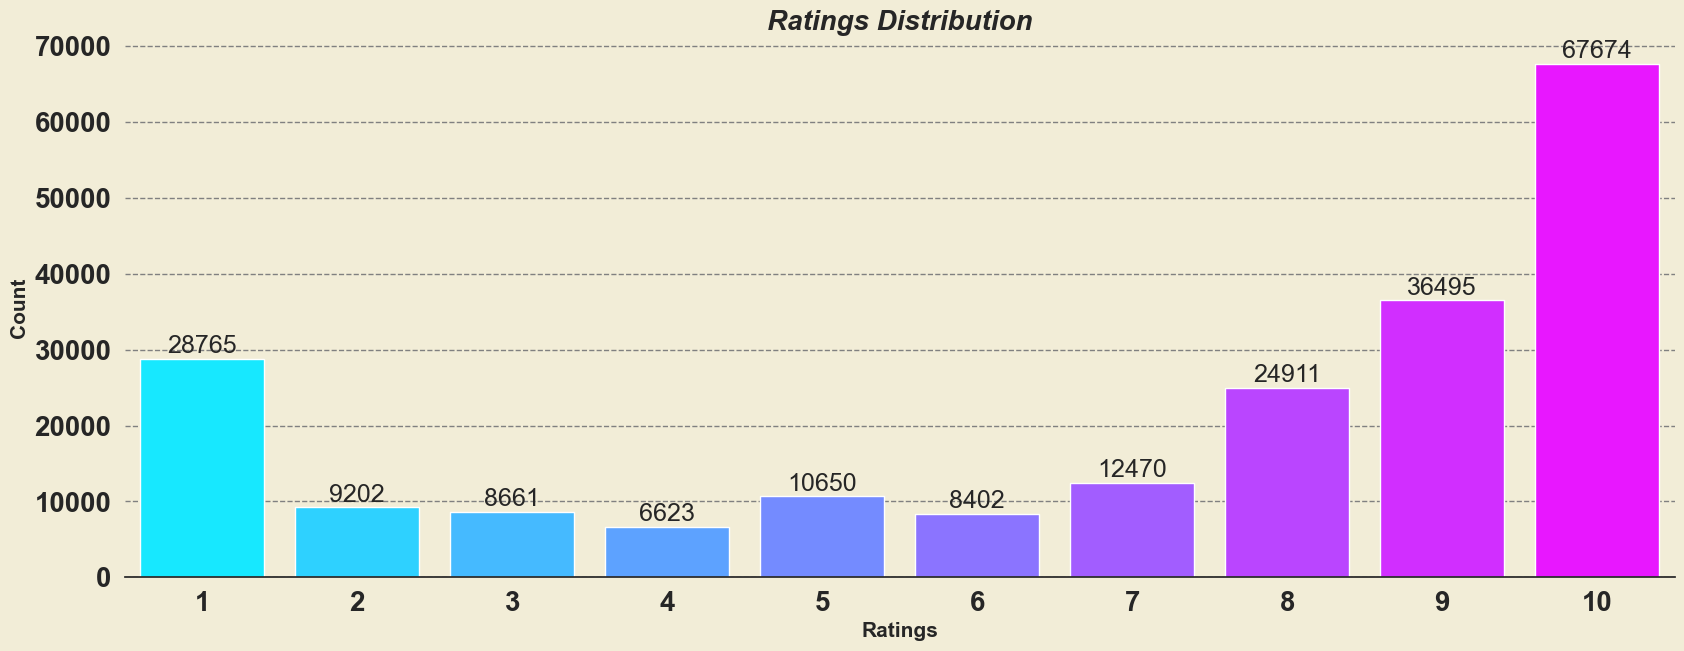

In [33]:
sns.set_theme(context='notebook',style='white',font_scale=1.5)

#setting the background and foreground color
fig=plt.figure(figsize=(20,7))
ax=plt.axes()
ax.set_facecolor("#F2EDD7FF")
fig.patch.set_color("#F2EDD7FF")

#Dealing with spines
for i in ['left','top','right']:
    ax.spines[i].set_visible(False)
    
ax.grid(linestyle="--",axis='y',color='gray')

#countplot
rate_plot=sns.countplot(data=new_df3,x='rating',saturation=3,palette='cool')
for p in rate_plot.patches:
    rate_plot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.xlabel("Ratings",weight='bold',fontsize=15)
plt.ylabel("Count",weight='bold',fontsize=15)
plt.xticks(weight='bold',fontsize=20)
plt.yticks(weight='bold',fontsize=20)
plt.title("Ratings Distribution",weight='bold',fontstyle='italic',fontsize=20)


In [52]:
#Count How many Pos/Mod/Neg Reviews

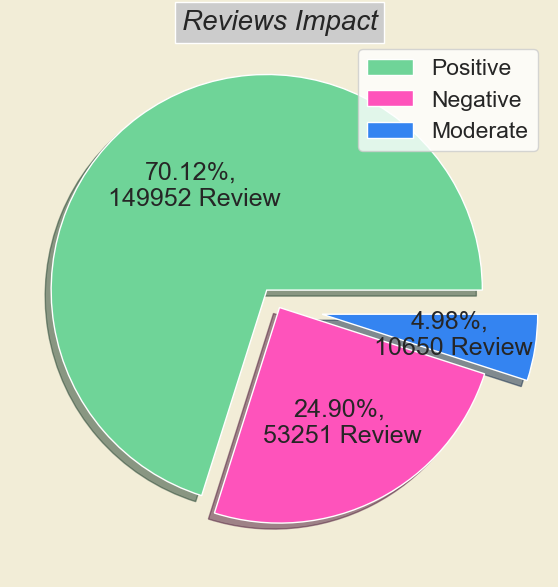

In [53]:
sns.set_theme(context='notebook',style='white',font_scale=1.5)

#setting the background and foreground color
fig=plt.figure(figsize=(20,7))
ax=plt.axes()
ax.set_facecolor("#F2EDD7FF")
fig.patch.set_color("#F2EDD7FF")

#Dealing with spines
for i in ['left','top','right']:
    ax.spines[i].set_visible(False)
    
ax.grid(linestyle="--",axis='y',color='gray')

label = list(new_df3.Indicator.value_counts().index)
 
data = list(new_df3.Indicator.value_counts())
explode = (0.1, 0.0, 0.2)


plt.pie(data,explode = explode,shadow=True,autopct=lambda p:f'{p:.2f}%,\n {p*sum(data)/100 :.0f} Review',colors=["#6fd498","#fe53bb","#3484f1"])
plt.title("Reviews Impact",bbox={'facecolor':'0.8', 'pad':5},fontsize=20,fontstyle='italic',loc="center")
plt.legend( label,loc="upper right")
plt.show()

In [54]:
#Most Repeated Conditions
repeated_con=new_df3.condition.value_counts().reset_index().head(20).rename(columns = {'condition':'values','index':'condition'})
repeated_con

,condition,values
0,Birth Control,38774
1,Depression,12200
2,Pain,8278
3,Anxiety,7842
4,Acne,7554
5,Bipolar Disorde,5631
6,Insomnia,4915
7,Weight Loss,4865
8,Obesity,4779
9,ADHD,4531


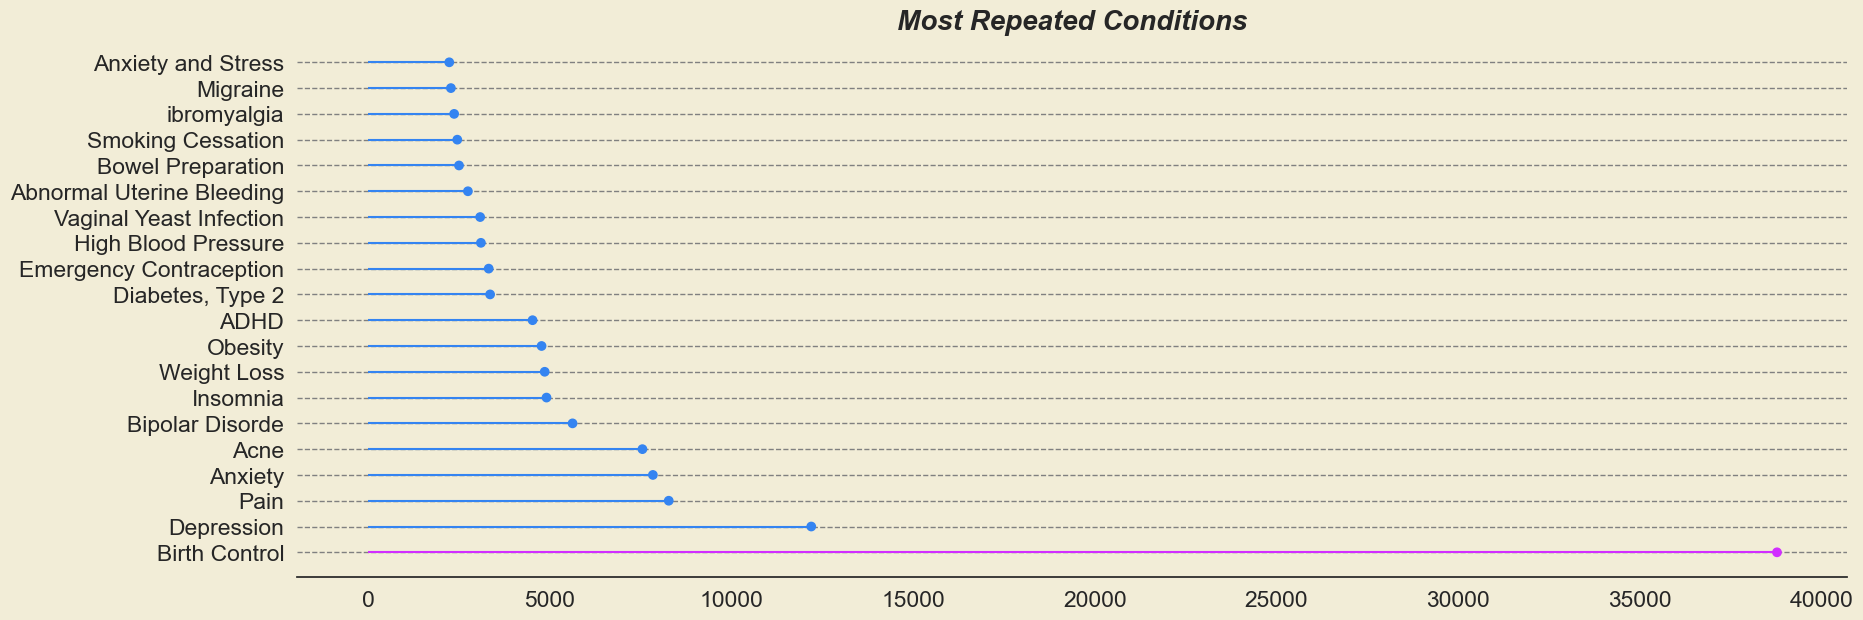

In [55]:
sns.set_theme(context='notebook',style='white',font_scale=1.5)

#setting the background and foreground color
fig=plt.figure(figsize=(20,7))
ax=plt.axes()
ax.set_facecolor("#F2EDD7FF")
fig.patch.set_color("#F2EDD7FF")

#Dealing with spines
for i in ['left','top','right']:
    ax.spines[i].set_visible(False)
    
ax.grid(linestyle="--",axis='y',color='gray')

my_range=range(1,len(repeated_con.index)+1)
my_color=np.where(repeated_con ['condition']=='Birth Control', '#d12eff', '#3484f1')


plt.hlines(y=my_range, xmin=0, xmax=repeated_con['values'],color=my_color,alpha=1)
plt.scatter(repeated_con['values'], my_range, color=my_color,alpha=1)


plt.yticks(my_range, repeated_con['condition'])
plt.title("Most Repeated Conditions",fontsize=20,fontstyle='italic',weight='bold')

plt.show()

In [56]:
#Most Repeated drugName
repeated_drug=new_df3.drugName.value_counts().reset_index().head(20).rename(columns = {'drugName':'values','index':'drugName'})
repeated_drug.head()

,drugName,values
0,Levonorgestrel,4930
1,Etonogestrel,4421
2,Ethinyl estradiol / norethindrone,3753
3,Nexplanon,2883
4,Ethinyl estradiol / norgestimate,2790


In [57]:
repeated_drug["comp"] = repeated_drug['drugName'] +"\n"+repeated_drug["values"].astype(str)+" Review"
repeated_drug

,drugName,values,comp
0,Levonorgestrel,4930,Levonorgestrel\n4930 Review
1,Etonogestrel,4421,Etonogestrel\n4421 Review
2,Ethinyl estradiol / norethindrone,3753,Ethinyl estradiol / norethindrone\n3753 Review
3,Nexplanon,2883,Nexplanon\n2883 Review
4,Ethinyl estradiol / norgestimate,2790,Ethinyl estradiol / norgestimate\n2790 Review
5,Ethinyl estradiol / levonorgestrel,2503,Ethinyl estradiol / levonorgestrel\n2503 Review
6,Phentermine,2085,Phentermine\n2085 Review
7,Sertraline,1868,Sertraline\n1868 Review
8,Escitalopram,1747,Escitalopram\n1747 Review
9,Mirena,1647,Mirena\n1647 Review


(0.0, 100.0, 0.0, 100.0)

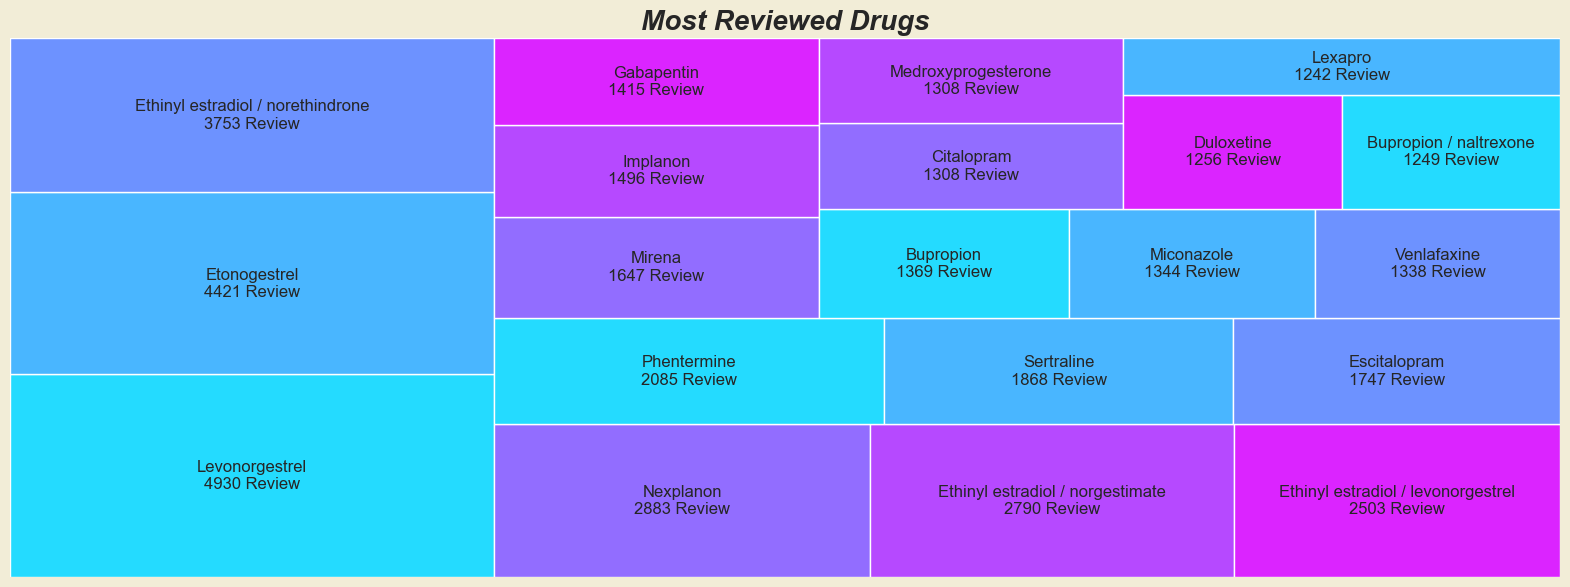

In [58]:
sns.set_theme(context='notebook',style='white',font_scale=1)

#setting the background and foreground color
fig=plt.figure(figsize=(20,7))
ax=plt.axes()
ax.set_facecolor("#F2EDD7FF")
fig.patch.set_color("#F2EDD7FF")

#Dealing with spines
for i in ['left','top','right']:
    ax.spines[i].set_visible(False)
ax.grid(linestyle="--",axis='y',color='gray')


episode_data = repeated_drug["values"]
anime_names = list(repeated_drug.comp)
squarify.plot(episode_data, label=anime_names,pad=0,color=sns.color_palette("cool"),text_kwargs={'fontsize': 12})
plt.title("Most Reviewed Drugs",fontsize=20,fontstyle='italic',weight='bold')

plt.axis("off")

Text(0.5, 1.0, 'Top20 : The number of drugs per condition.')

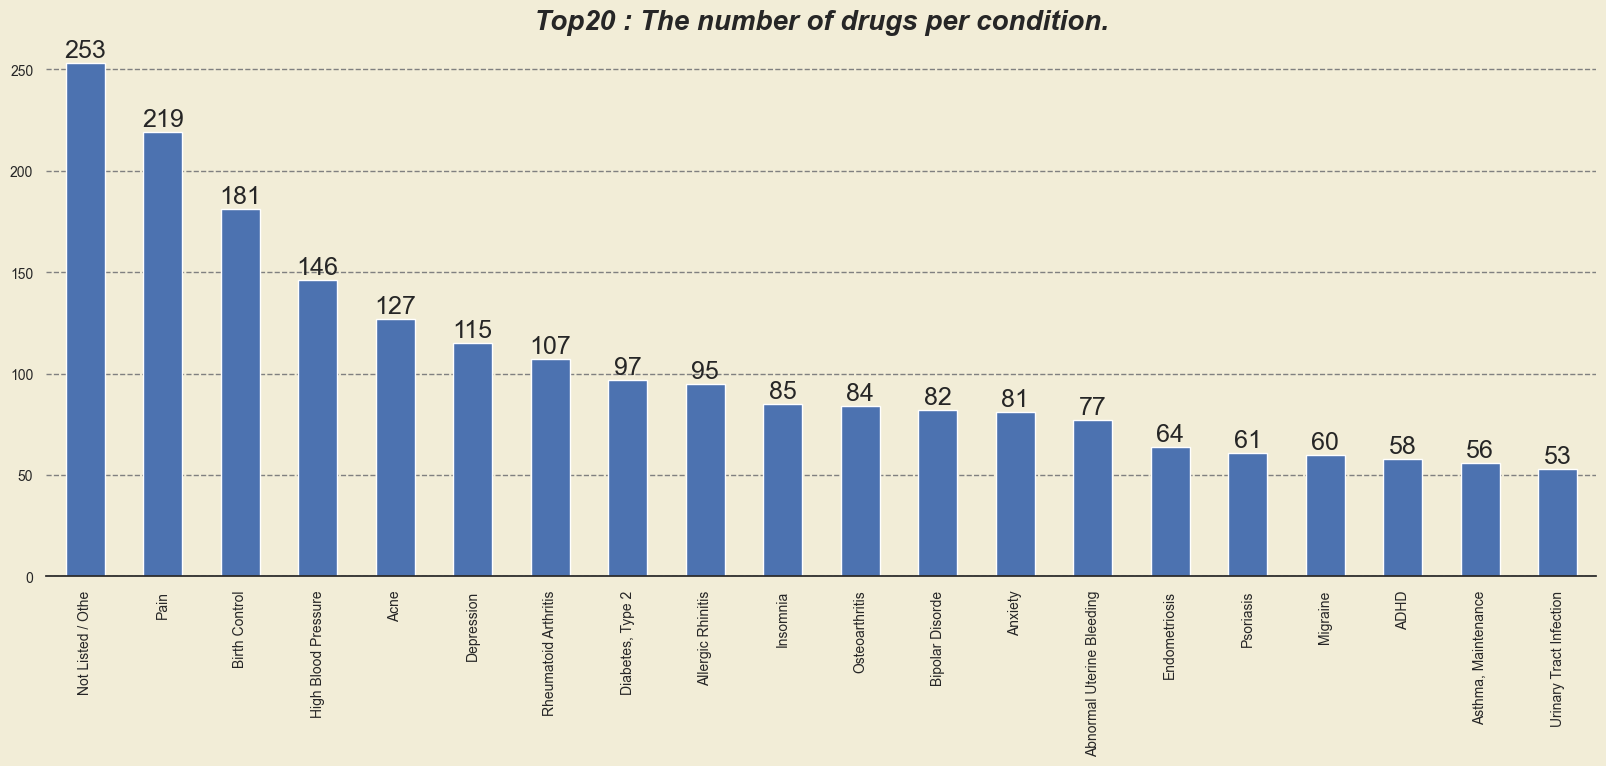

In [59]:
#The number of drugs per condition
sns.set_theme(context='notebook',style='white',font_scale=1.5)

#setting the background and foreground color
fig=plt.figure(figsize=(20,7))
ax=plt.axes()
ax.set_facecolor("#F2EDD7FF")
fig.patch.set_color("#F2EDD7FF")

#Dealing with spines
for i in ['left','top','right']:
    ax.spines[i].set_visible(False)

condition_dn = new_df3.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
condition_dn_plot=condition_dn[0:20].plot(kind="bar", fontsize = 10)

for p in condition_dn_plot.patches:
    condition_dn_plot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
ax.grid(linestyle="--",axis='y',color='gray')

plt.title("Top20 : The number of drugs per condition.", fontsize = 20,fontstyle='italic',weight='bold')

In [60]:
#reviews over tim
year_hst=new_df3.review_Year.value_counts().sort_index()
month_hst=new_df3.review_Month.value_counts().sort_index()
day_hst=new_df3.review_Day.value_counts().sort_index()

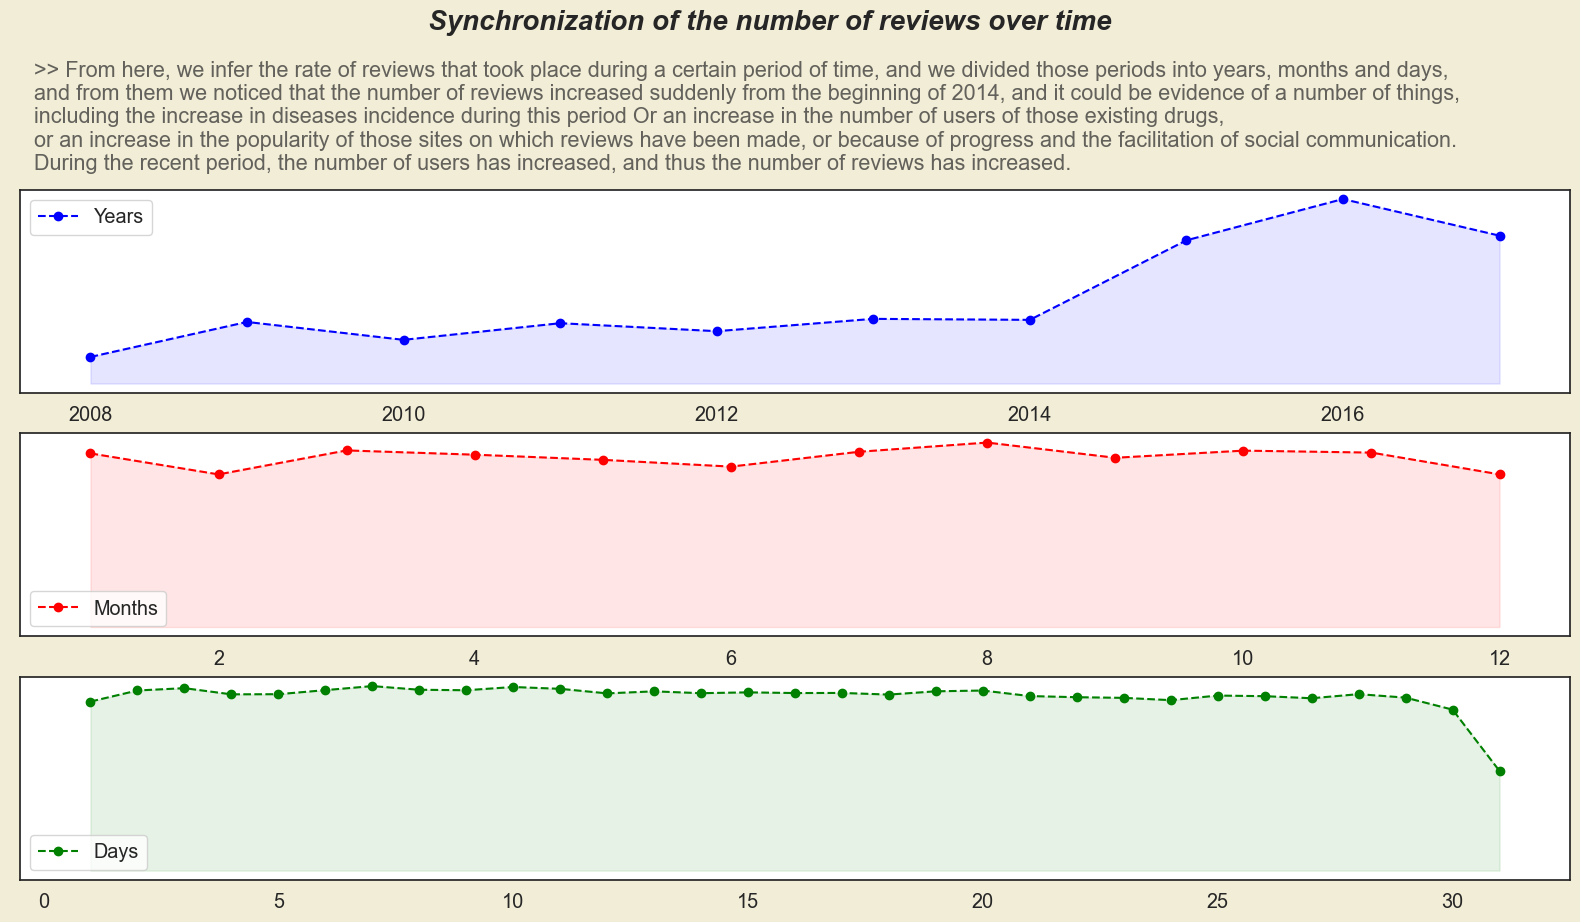

In [131]:
fig, (ax1,ax2,ax3) = plt.subplots(3,figsize=(20, 10))
fig.patch.set_color("#F2EDD7FF")
fig.suptitle('Synchronization of the number of reviews over time',fontsize = 20,fontstyle='italic',weight='bold')
plt.subplots_adjust(top=0.8) 

txt = '''
    >> From here, we infer the rate of reviews that took place during a certain period of time, and we divided those periods into years, months and days, 
    and from them we noticed that the number of reviews increased suddenly from the beginning of 2014, and it could be evidence of a number of things,
    including the increase in diseases incidence during this period Or an increase in the number of users of those existing drugs,
    or an increase in the popularity of those sites on which reviews have been made, or because of progress and the facilitation of social communication. 
    During the recent period, the number of users has increased, and thus the number of reviews has increased.'''

fig.text(.12,.82,txt,alpha=0.7)


ax1.plot(year_hst.index,year_hst.values,color='blue',marker="o",linestyle = 'dashed',label="Years")
ax1.fill_between(year_hst.index,year_hst.values, 0, color='blue', alpha=.1)
ax1.set_yticks([])

ax2.plot(month_hst.index,month_hst.values,color='red',marker="o",linestyle = 'dashed',label="Months")
ax2.fill_between(month_hst.index,month_hst.values, 0, color='red', alpha=.1)
ax2.set_yticks([])

ax3.plot(day_hst.index,day_hst.values,color='green',marker="o",linestyle = 'dashed',label="Days")
ax3.fill_between(day_hst.index,day_hst.values, 0, color='green', alpha=.1)
ax3.set_yticks([])

ax1.legend(loc='best')
ax2.legend(loc='best')
ax3.legend(loc='best')

plt.show()

In [62]:
#Positive WordCloud
pos=list(new_df3.loc[new_df3['Indicator'] == "Positive"]["cleaned_reveiw"])
pos_words=' '.join(pos)
cleaned_pos = remove_stopwords(pos_words)
pos_dict=dict(Counter(cleaned_pos.split(" ")))
words_Positive=pd.DataFrame(pos_dict,index=[0]).T

In [63]:
words_Positive.columns=["repeating"]
words_Positive=words_Positive.sort_values(by='repeating',ascending=False)
words_Positive2=words_Positive.reset_index()
words_Positive2

,index,repeating
0,day,53255
1,years,50085
2,taking,46761
3,effects,43806
4,pain,41538
...,...,...
61015,migrelief,1
61016,midozalm,1
61017,probelms,1
61018,xrgeneric,1


In [64]:
words_Positive2.columns=["word","repeat"]

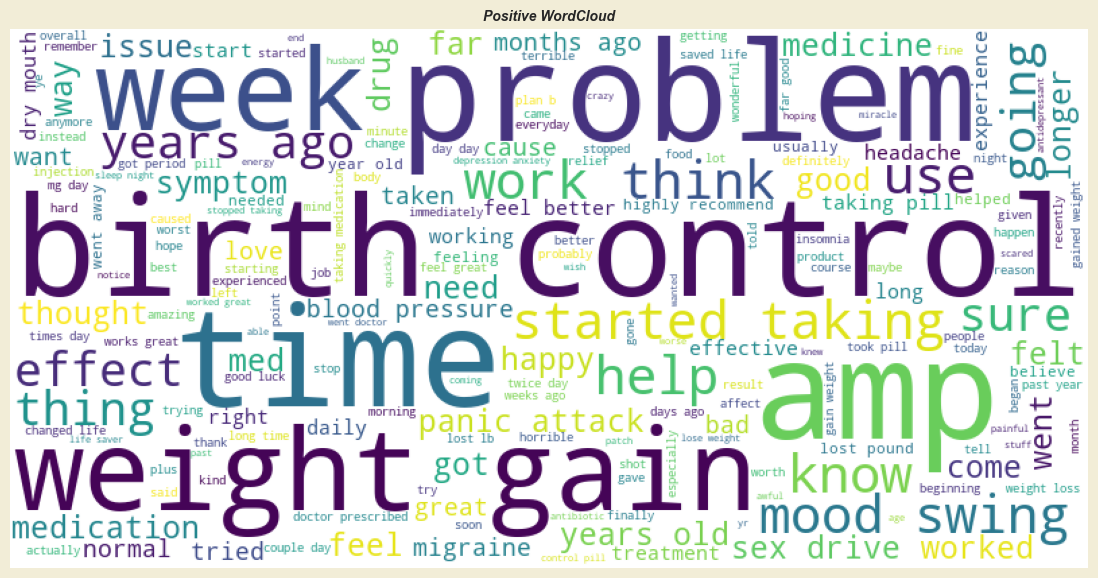

In [65]:
fig=plt.figure(figsize=(25,7))
fig.patch.set_color("#F2EDD7FF")
wordcloud = WordCloud(width=800, 
                      height=400,
                      prefer_horizontal=0.9,
                      background_color="rgb(255, 255, 255)",
                      repeat=True,
                      mode="RGBA").generate(cleaned_pos)
plt.title("Positive WordCloud",fontsize = 10,fontstyle='italic',weight='bold')
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [66]:
#Negative WordCloud
neg=list(new_df3.loc[new_df3['Indicator'] == "Negative"]["cleaned_reveiw"])
neg_words=' '.join(neg)
cleaned_neg = remove_stopwords(neg_words)
neg_dict=dict(Counter(cleaned_neg.split(" ")))
words_Negative=pd.DataFrame(neg_dict,index=[0]).T
words_Negative.columns=["repeating"]
words_Negative=words_Negative.sort_values(by='repeating',ascending=False)
words_Negative2=words_Negative.reset_index()
words_Negative2.columns=["word","repeat"]

In [67]:
words_Negative2

,word,repeat
0,taking,17246
1,day,16757
2,months,15771
3,pain,14900
4,like,14863
...,...,...
32171,metejectleflunamide,1
32172,waning,1
32173,amplifies,1
32174,methotrexateplus,1


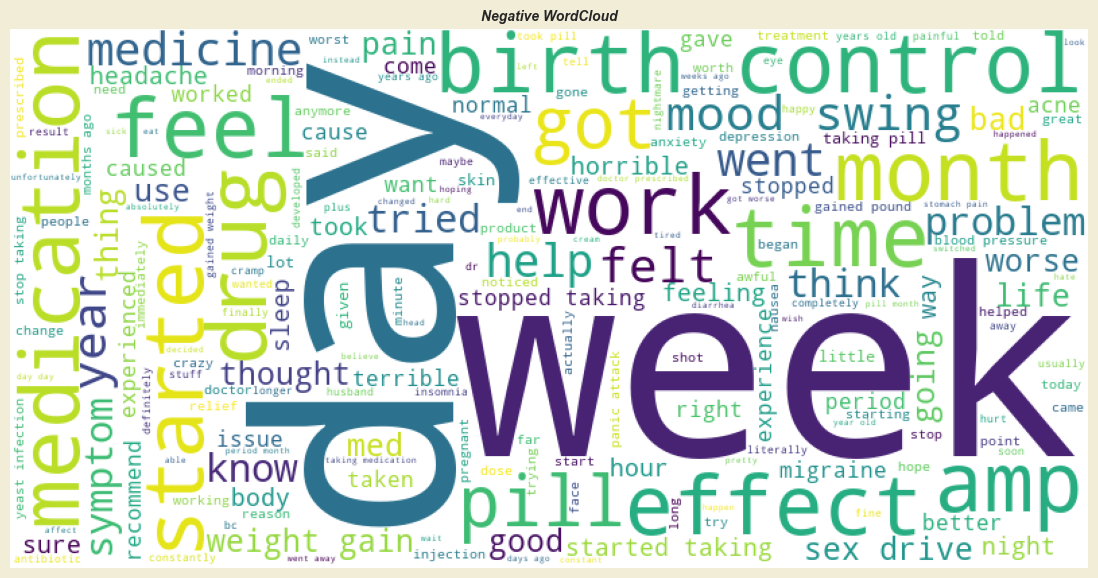

In [68]:
fig=plt.figure(figsize=(25,7))
fig.patch.set_color("#F2EDD7FF")
wordcloud = WordCloud(width=800, 
                      height=400,
                      prefer_horizontal=0.9,
                      background_color="rgb(255, 255, 255)",
                      repeat=True,
                      mode="RGBA").generate(cleaned_neg)
plt.title("Negative WordCloud",fontsize = 10,fontstyle='italic',weight='bold')
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

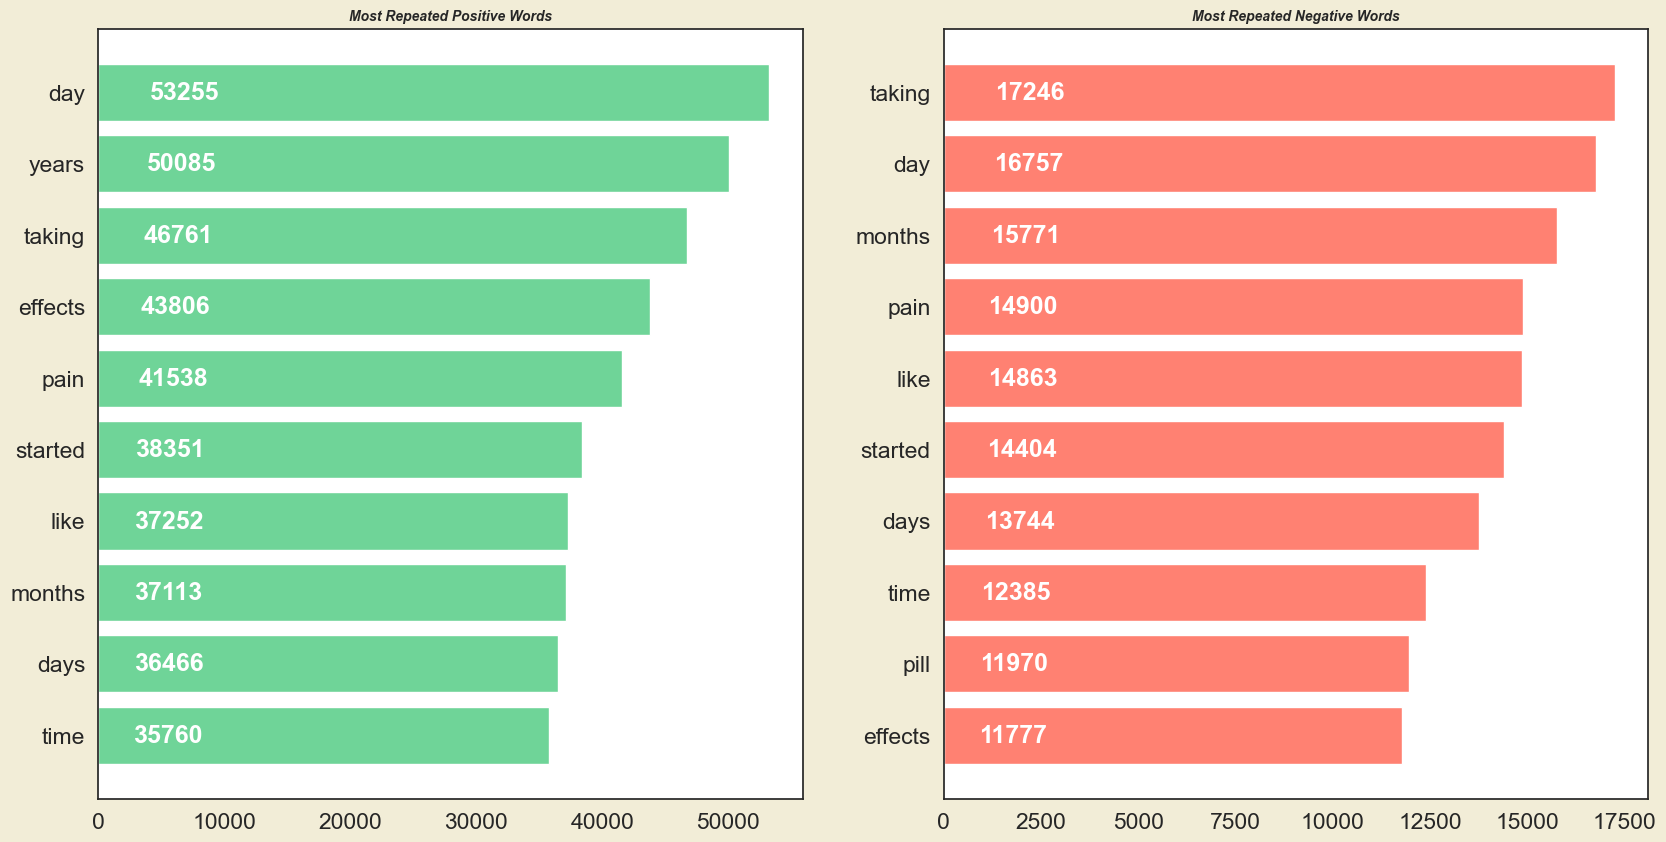

In [69]:
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(20, 10))
fig.patch.set_color("#F2EDD7FF")


ax1.barh(width=words_Positive2.repeat.head(10)[::-1],y=words_Positive2.word.head(10)[::-1],color='#6fd498')
ax1.set_title("Most Repeated Positive Words",fontsize = 10,fontstyle='italic',weight='bold')
for i, v in enumerate(words_Positive2.repeat.head(10)[::-1]):
    ax1.text(v/13, i + -0.1, str(v), color='white', fontweight='bold')
    
ax2.barh(width=words_Negative2.repeat.head(10)[::-1],y=words_Negative2.word.head(10)[::-1],color='#ff8172')
ax2.set_title("Most Repeated Negative Words",fontsize = 10,fontstyle='italic',weight='bold')
for i, v in enumerate(words_Negative2.repeat.head(10)[::-1]):
    ax2.text(v/13, i + -0.1, str(v), color='white', fontweight='bold')

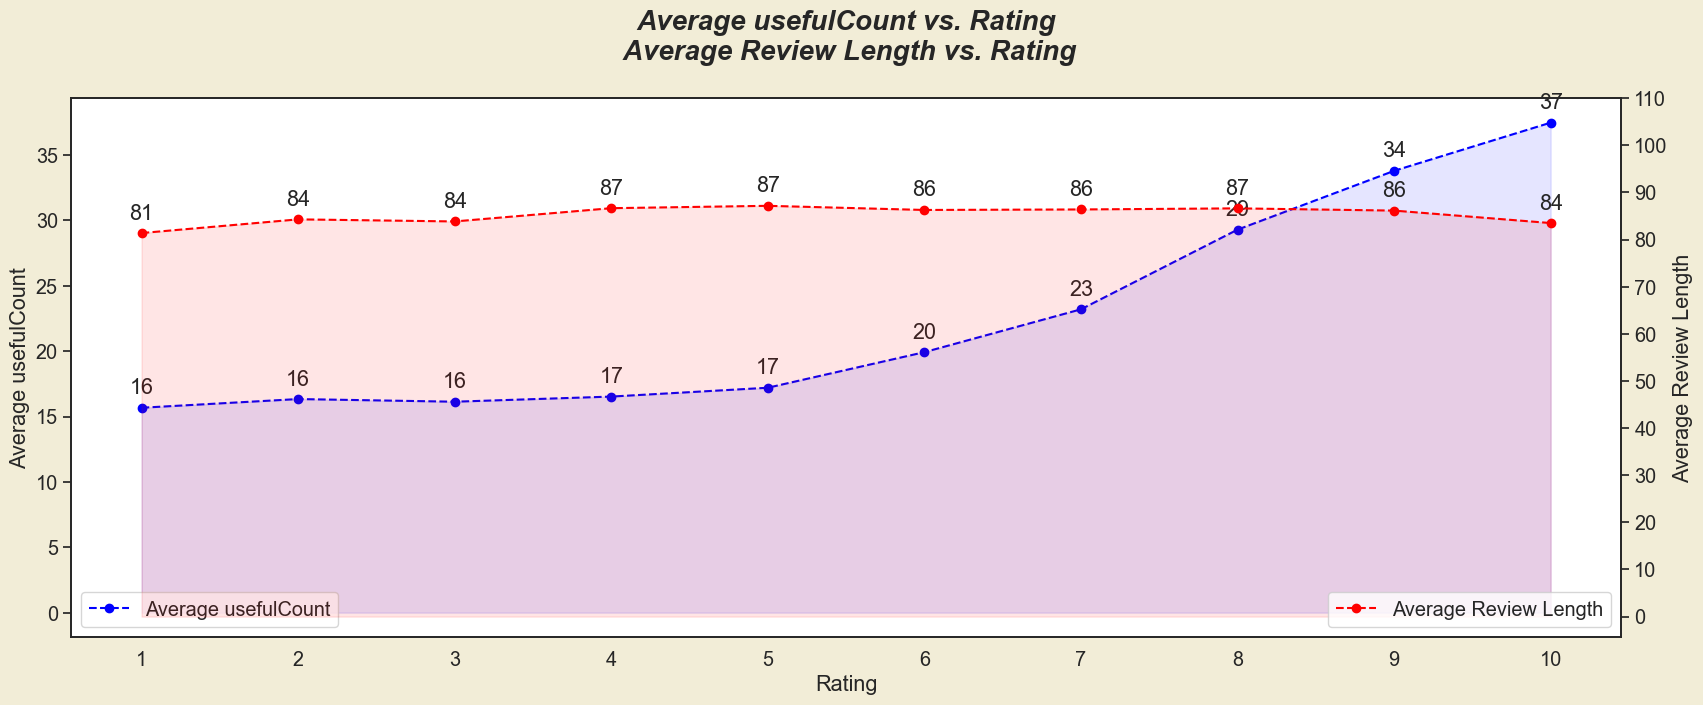

In [15]:
new_df_rev=df_all
new_df_rev['reviewLength'] = new_df_rev.review.apply(lambda x: len(x.split()))
new_df_rev['reviewLength'] = df_test.review.apply(lambda x: len(x.split()))

sns.set_theme(context='notebook',style='white',font_scale=1.3)

#setting the background and foreground color
fig=plt.figure(figsize=(20,7))
ax=plt.axes()
ax.set_facecolor("white")
fig.patch.set_color("#F2EDD7FF")

# -------------------------------------------------------------------------------->

t = range(1,11)

ax.set_xlabel('Rating')
ax.set_ylabel('Average usefulCount')
ax.plot(t, new_df_rev.groupby('rating').usefulCount.mean(),color='blue',marker="o",linestyle = 'dashed',label="Average usefulCount")
ax.fill_between(t, new_df_rev.groupby('rating').usefulCount.mean(), 0, color='blue', alpha=.1)

for x,y in zip(t, new_df_rev.groupby('rating').usefulCount.mean()):
    label = "{:.0f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

ax.set_xticks(range(0,11,1))
ax.tick_params(axis='y')

# -------------------------------------------------------------------------------->

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('Average Review Length')  # we already handled the x-label with ax1
ax2.plot(t, new_df_rev.groupby('rating').reviewLength.mean(),color='red',marker="o",linestyle = 'dashed',label="Average Review Length")
ax2.fill_between(t, new_df_rev.groupby('rating').reviewLength.mean(), 0, color='red', alpha=.1)

for x,y in zip(t, new_df_rev.groupby('rating').reviewLength.mean()):

    label = "{:.0f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
ax2.set_yticks(range(0,120,10))

# -------------------------------------------------------------------------------->

ax.set_title('Average usefulCount vs. Rating\n Average Review Length vs. Rating\n',fontsize = 20,fontstyle='italic',weight='bold')
ax.legend(loc='lower left')
ax2.legend(loc='lower right')
plt.show()

# 5-Pre-Modeling

In [70]:
new_df3.head()

,drugName,condition,rating,usefulCount,cleaned_reveiw,review_Year,review_Month,review_Day,Indicator
0,Valsartan,Left Ventricular Dysfunction,9,27,it has no side effect i take it in combination...,2012,5,20,Positive
1,Guanfacine,ADHD,8,192,my son is halfway through his fourth week of i...,2010,4,27,Positive
2,Lybrel,Birth Control,5,17,i used to take another oral contraceptive whic...,2009,12,14,Moderate
3,Ortho Evra,Birth Control,8,10,this is my first time using any form of birth ...,2015,11,3,Positive
4,Buprenorphine / naloxone,Opiate Dependence,9,37,suboxone has completely turned my life around ...,2016,11,27,Positive


In [71]:
new_df3["Re_Cleaned_review"]=new_df3["cleaned_reveiw"].apply(lambda x:remove_stopwords(x))

In [72]:
new_df3

,drugName,condition,rating,usefulCount,cleaned_reveiw,review_Year,review_Month,review_Day,Indicator,Re_Cleaned_review
0,Valsartan,Left Ventricular Dysfunction,9,27,it has no side effect i take it in combination...,2012,5,20,Positive,effect combination bystolic mg fish oil
1,Guanfacine,ADHD,8,192,my son is halfway through his fourth week of i...,2010,4,27,Positive,son halfway fourth week intuniv concerned bega...
2,Lybrel,Birth Control,5,17,i used to take another oral contraceptive whic...,2009,12,14,Moderate,oral contraceptive pill cycle happy light peri...
3,Ortho Evra,Birth Control,8,10,this is my first time using any form of birth ...,2015,11,3,Positive,time form birth control glad went patch months...
4,Buprenorphine / naloxone,Opiate Dependence,9,37,suboxone has completely turned my life around ...,2016,11,27,Positive,suboxone completely turned life feel healthier...
...,...,...,...,...,...,...,...,...,...,...
52424,Quetiapine,Bipolar Disorde,7,10,good for insomnia most of the time,2015,5,27,Positive,good insomnia time
52488,Ethinyl estradiol / levonorgestrel,Birth Control,5,4,i am almost on my third month of my first pack...,2011,4,25,Moderate,month pack jolessa bleeding weeks spotting tim...
52617,Ethinyl estradiol / levonorgestrel,Birth Control,10,1,i have been taking this birth control for two ...,2011,1,11,Positive,taking birth control years love problems works...
52742,Medroxyprogesterone,Endometriosis,10,1,i have been using the shot for years now and ...,2011,4,21,Positive,shot years love worry period experienced chang...


<AxesSubplot:>

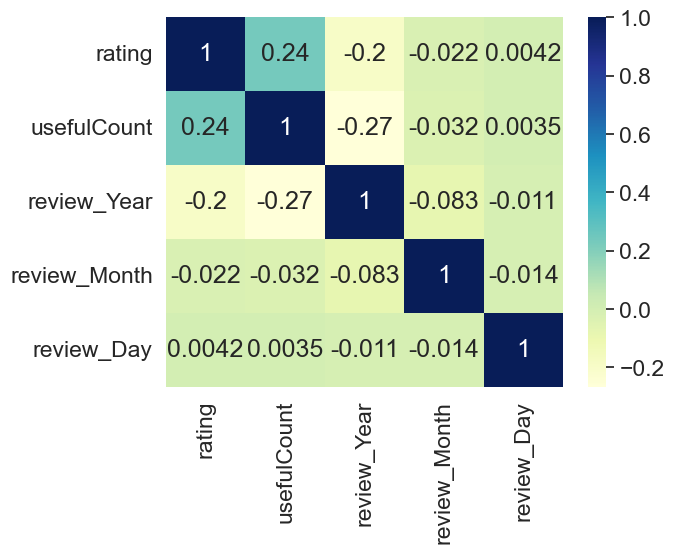

In [73]:
sns.heatmap(new_df3.corr(), cmap="YlGnBu", annot=True)

In [74]:
#Drop Unnecessary Columns
new_df4=new_df3[["drugName","condition","rating","usefulCount","Re_Cleaned_review","review_Year"]]
new_df4

,drugName,condition,rating,usefulCount,Re_Cleaned_review,review_Year
0,Valsartan,Left Ventricular Dysfunction,9,27,effect combination bystolic mg fish oil,2012
1,Guanfacine,ADHD,8,192,son halfway fourth week intuniv concerned bega...,2010
2,Lybrel,Birth Control,5,17,oral contraceptive pill cycle happy light peri...,2009
3,Ortho Evra,Birth Control,8,10,time form birth control glad went patch months...,2015
4,Buprenorphine / naloxone,Opiate Dependence,9,37,suboxone completely turned life feel healthier...,2016
...,...,...,...,...,...,...
52424,Quetiapine,Bipolar Disorde,7,10,good insomnia time,2015
52488,Ethinyl estradiol / levonorgestrel,Birth Control,5,4,month pack jolessa bleeding weeks spotting tim...,2011
52617,Ethinyl estradiol / levonorgestrel,Birth Control,10,1,taking birth control years love problems works...,2011
52742,Medroxyprogesterone,Endometriosis,10,1,shot years love worry period experienced chang...,2011


In [75]:
new_df4['cleaned_condition']=new_df4['condition'].apply(text_cleaning)

In [76]:
new_df5=new_df4.drop("condition",axis=1)

In [77]:
new_df5.duplicated().sum()

2

In [78]:
new_df5.drop_duplicates(inplace=True)

In [79]:
le=LabelEncoder()
new_df5['cleaned_condition']=le.fit_transform(new_df5["cleaned_condition"])
new_df5.head()

,drugName,rating,usefulCount,Re_Cleaned_review,review_Year,cleaned_condition
0,Valsartan,9,27,effect combination bystolic mg fish oil,2012,413
1,Guanfacine,8,192,son halfway fourth week intuniv concerned bega...,2010,17
2,Lybrel,5,17,oral contraceptive pill cycle happy light peri...,2009,102
3,Ortho Evra,8,10,time form birth control glad went patch months...,2015,102
4,Buprenorphine / naloxone,9,37,suboxone completely turned life feel healthier...,2016,542


In [80]:
index_condition=pd.DataFrame(le.classes_)
index_condition.columns=["Condition"]
index_condition

,Condition
0,nutritional deficiency
1,proteinase inhibitor deficiency
2,abdominal distension
3,abnormal uterine bleeding
4,abortion
...,...
830,wound cleansing
831,xerostomia
832,yellow fever prophylaxis
833,zen shoulde


In [ ]:
new_df5.to_csv("Model_Data.csv",index=False)
index_condition.to_csv("Conditions_index.csv",index=False)